In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import datatable as dt
dt.options.nthreads = 1
from multiprocessing import Pool
from tqdm.auto import tqdm

2

In [2]:
# point path to IEBM files
import sys
sys.path.append('../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import base Trait class to set up Events
from iebm.traits.base import Trait
# import BirthEvent for the prey
from iebm.events.birth import BirthEvent
# import DeathEvent for the predator
from iebm.events.death import DeathEvent
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import class to simulate model
from iebm.simulation import Simulation

In [3]:
r = 0.001 # prey growth rate
a = 1 # predator attack rate
c = 1 # predator conversion efficiency
d = 0.001 # predator death rate
# size of environment
xdim = 500 
ydim = 500
A = xdim * ydim
init_prey = 200 # starting prey population size
init_pred = 200 # starting predator population size

# set the simulation time to certain number of cycles
num_cycles = 200
time = 1 / (np.sqrt(r * d) / (2 * np.pi)) * num_cycles

# for the IEBM, individuals need explicit size
prey_radius = 1.0
pred_radius = 1.0

# pred velocity, given stationary prey
vel = a / (2 * (prey_radius + pred_radius))

# metabolic coefficients
Br = r / (prey_radius**(-1/4))
Bd = d / (pred_radius**(-1/4))

In [4]:
def run():

    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    trait_prey = [(Trait, {'name' : 'radius', 
                           'init_value' : prey_radius, 
                           'track' : True, 
                           'min_value' : 0.1,
                           'max_value' : 2, 
                           'mutate_rate' : 0.01, 
                           'mutate_step' : 0.01}), 
                  (Trait, {'name' : 'predation_radius', 
                           'link_trait' : 'radius', 
                           'link_func' : lambda x: x}), 
                  (Trait, {'name' : 'birth_rate', 
                           'link_trait' : 'radius', 
                           'link_func' : lambda x: Br * x**(-1/4)})]
    prey.add_traits(trait_prey)

    event_list = [(BirthEvent, {'name' : 'birth' , 
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    prey.add_events(event_list)

    trait_pred = [(Trait, {'name' : 'radius', 
                           'init_value' : pred_radius,
                           'track' : True, 
                           'min_value' : 0.1,
                           'max_value' : 2, 
                           'mutate_rate' : 0.01, 
                           'mutate_step' : 0.01}), 
                  (Trait, {'name' : 'predation_radius', 
                           'link_trait' : 'radius', 
                           'link_func' : lambda x: x}),
                  (Trait, {'name' : 'velocity', 
                           'init_value' : vel}),
                  (Trait, {'name' : 'death_rate', 
                           'init_value' : d})]
    pred.add_traits(trait_pred)

    event_list = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                   'is_primary' : True,
                                   'current_time'  : 0, 
                                   'main_event' : (BirthEvent, {'current_time' : 0}), 
                                   'other' : prey, 
                                   'other_event' : (DeathEvent, {'current_time' : 0})}), 
                  (BirthEvent, {'name' : 'birth', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    pred.add_events(event_list)  

    prey.event_dict['birth'].triggers = pred.event_dict['predation'].set_other_next

    def predation_trigger(params):
        events = []
        other_params = params.copy()
        other_params['actor_id'] = other_params['other_id']
        events += prey.event_dict['death'].handle(other_params)
        events += pred.event_dict['birth'].handle(params)
        return events
    pred.event_dict['predation'].triggers = predation_trigger

    pred.event_dict['wall'].triggers = pred.event_dict['predation'].set_next

    pop_dict = {str(prey) : prey, 
                str(pred) : pred}

    sim = Simulation(pop_dict)

    sim.run(time)
    
    return sim

In [5]:
%%time
sim = run()

CPU times: user 34.4 s, sys: 3.49 s, total: 37.9 s
Wall time: 33.9 s


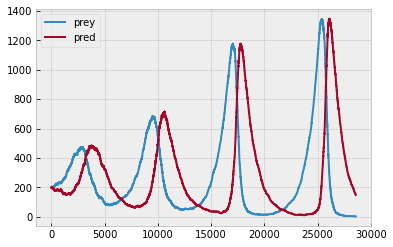

In [6]:
fig, ax = plt.subplots()
for k in sim.population_history:
    ax.plot(sim.time_history, sim.population_history[k], label=k)
plt.legend()
plt.show()

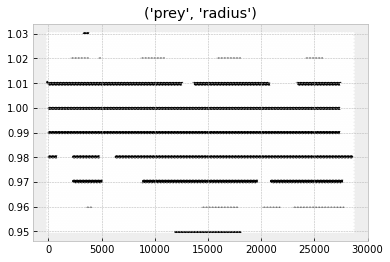

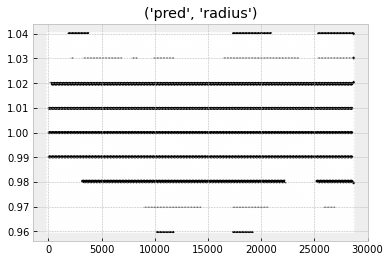

In [28]:
for k in sim.trait_history:
    trait_hist = sim.trait_history[k]
    times, traits, freqs = [], [], []
    for i,(t,c) in zip(sim.time_history, trait_hist):
        times.extend([i]*len(t))
        traits.extend(t)
        freqs.extend(c / c.sum())
    fig, ax = plt.subplots()
    ax.hexbin(times, traits, gridsize=100, bins='log', vmax=2, cmap='Greys')
    ax.set_title(k)
    plt.show()